### Take a look at RPEs from John's behavioral model, plot them out for a few sessions, along with block switches and cor/inc

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.behavioral_utils as behavioral_utils

import os
import pandas as pd
import matplotlib

In [3]:
def get_rpes_per_session(session, beh):
    probs_path = f"/data/082023_RL_Probs/sess-{session}_hv.csv"
    probs = pd.read_csv(probs_path)
    probs["RPE_FE"] = probs.fb - probs.Prob_FE
    probs["RPE_FD"] = probs.fb - probs.Prob_FD
    probs["RPE_FRL"] = probs.fb - probs.Prob_FRL
    merged = pd.merge(beh, probs, left_on="TrialNumber", right_on="trial", how="inner")
    return merged


    

In [4]:
session = 20180802
beh_path = f"/data/rawdata/sub-SA/sess-{session}/behavior/sub-SA_sess-{session}_object_features.csv"
beh = pd.read_csv(beh_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
beh_w_rpes = get_rpes_per_session(session, valid_beh)
assert len(valid_beh) == len(beh_w_rpes)
beh_to_plot = beh_w_rpes[beh_w_rpes.BlockNumber < 8]

### Plot the 1st 6 "valid" blocks of 1 session

In [5]:
block_switches = beh_to_plot[beh_to_plot.TrialAfterRuleChange == 0].TrialNumber.values - 0.5

In [6]:
trials = beh_to_plot.TrialNumber
rpe_fe = beh_to_plot.RPE_FE.values
neg_fb_trials = beh_to_plot[beh_to_plot.fb == 0].trial.values
pos_fb_trials = beh_to_plot[beh_to_plot.fb == 1].trial.values

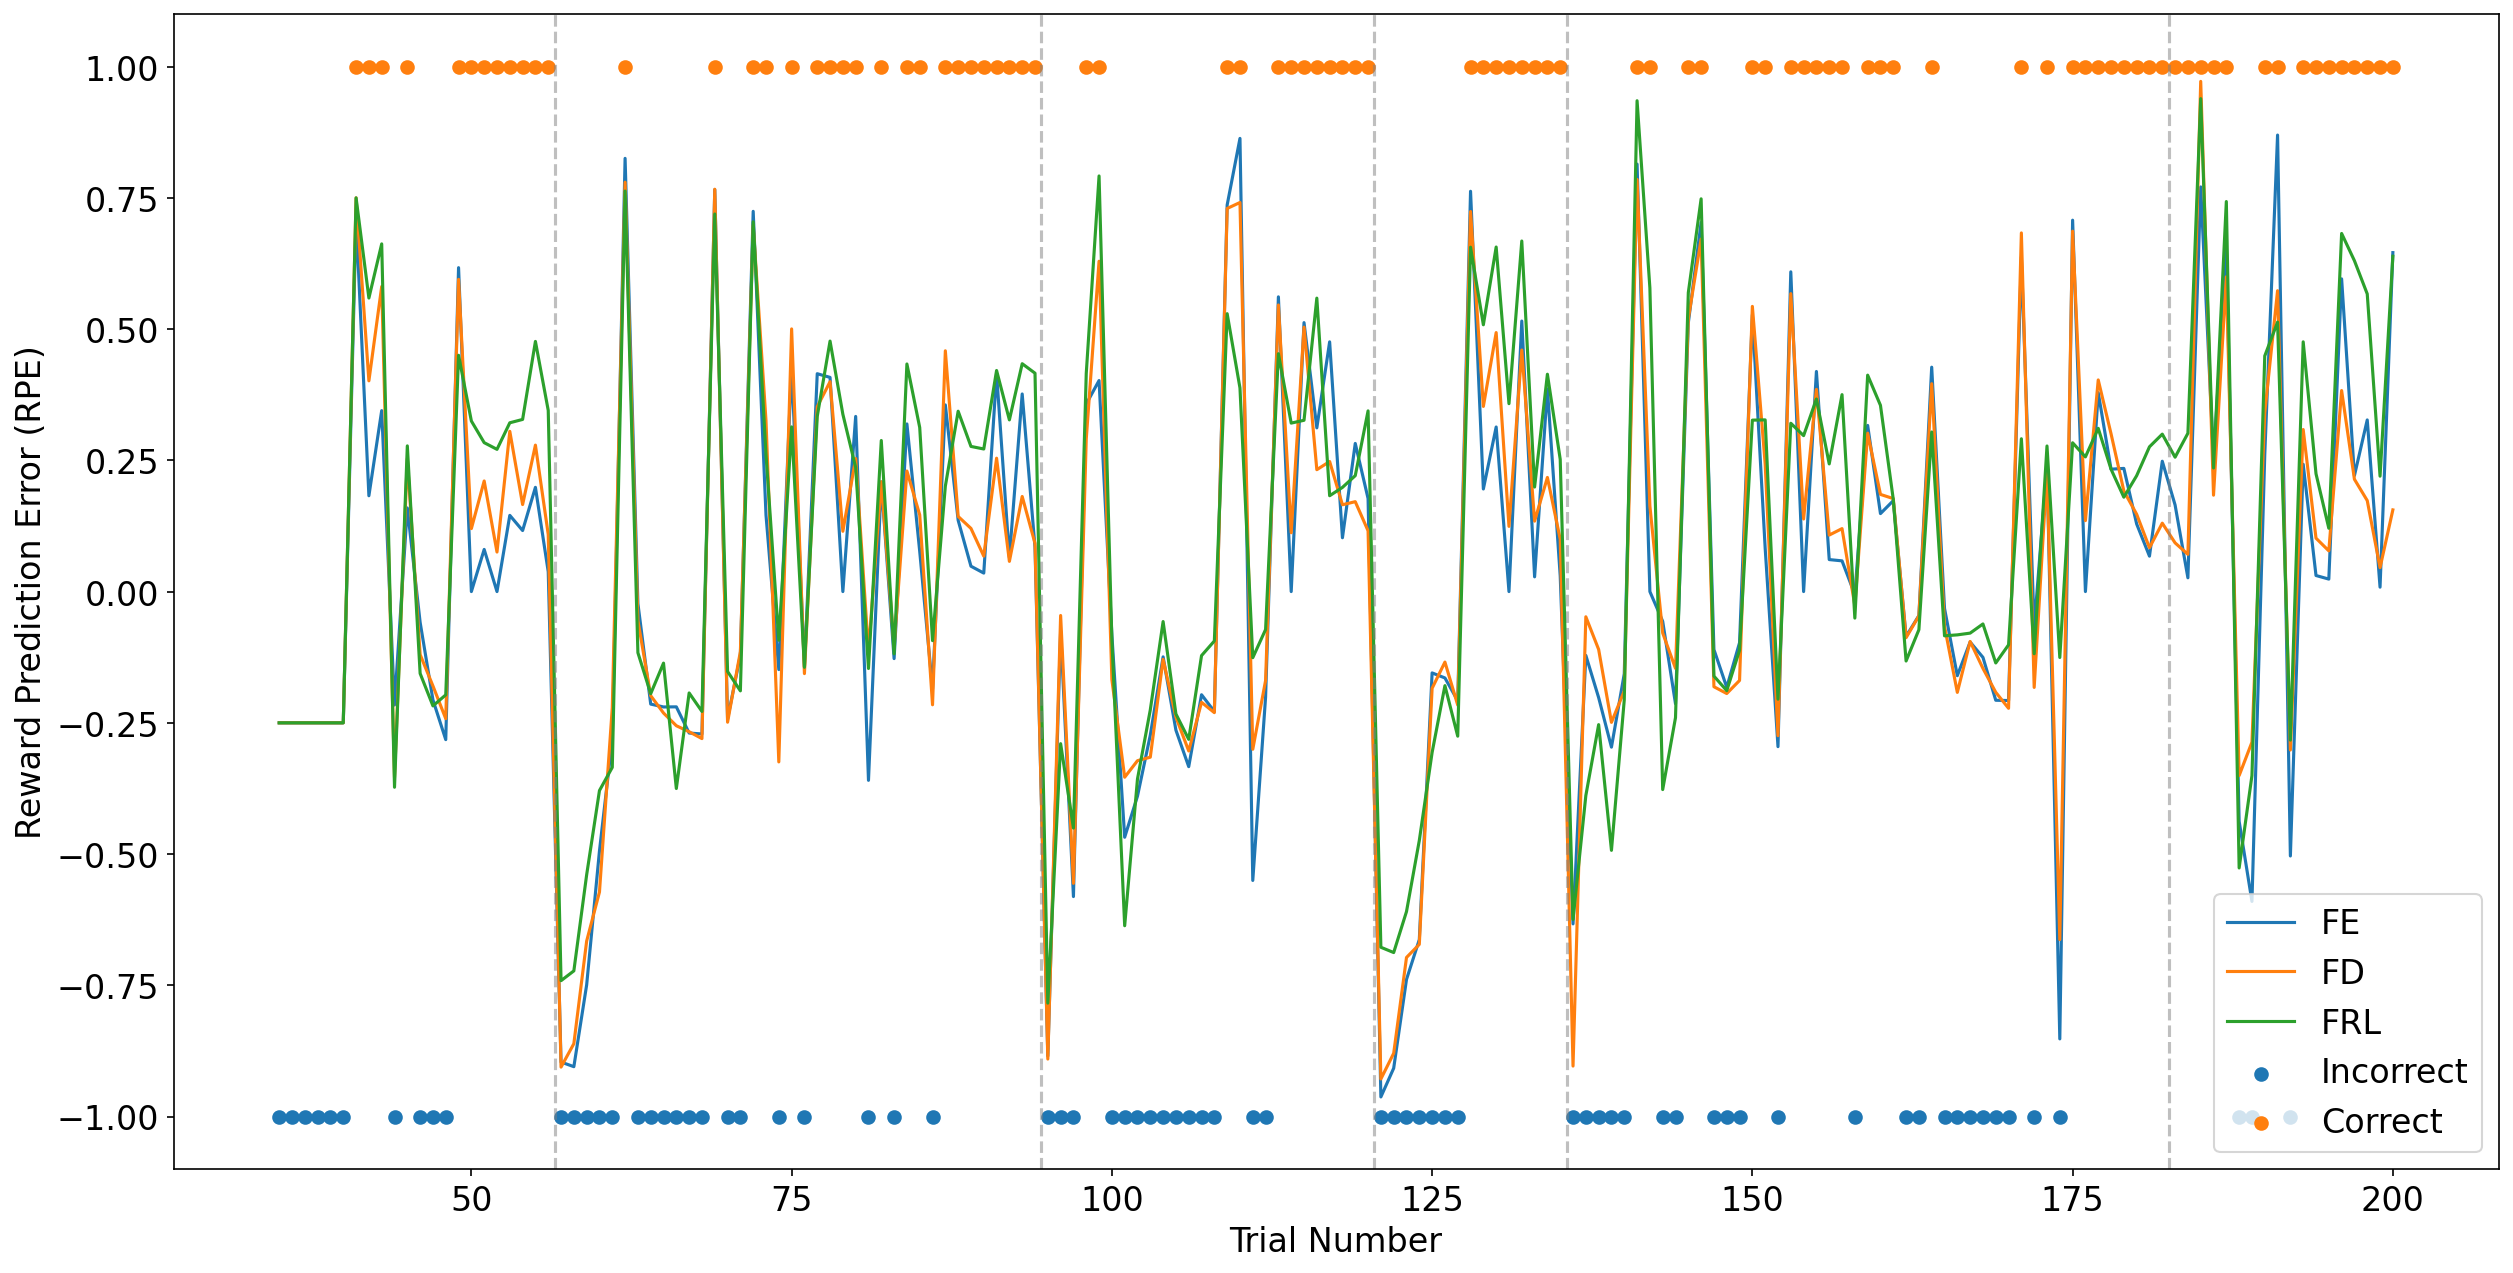

In [7]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(20, 10), dpi=150)

ax.plot(trials, beh_to_plot.RPE_FE.values, label="FE")
ax.plot(trials, beh_to_plot.RPE_FD.values, label="FD")
ax.plot(trials, beh_to_plot.RPE_FRL.values, label="FRL")

ax.scatter(neg_fb_trials, np.ones(len(neg_fb_trials)) * -1, label="Incorrect")
ax.scatter(pos_fb_trials, np.ones(len(pos_fb_trials)) * 1, label="Correct")
for block_switch in block_switches[1:]:
    ax.axvline(block_switch, alpha=0.5, color='gray', linestyle='dashed')
ax.set_xlabel("Trial Number")
ax.set_ylabel("Reward Prediction Error (RPE)")
ax.legend()

### Plot a histogram of each of the RPE values for this session

In [8]:
bins = np.arange(-1, 1.05, 0.05)

Text(0.5, 1.0, 'Histogram of RPE values across session')

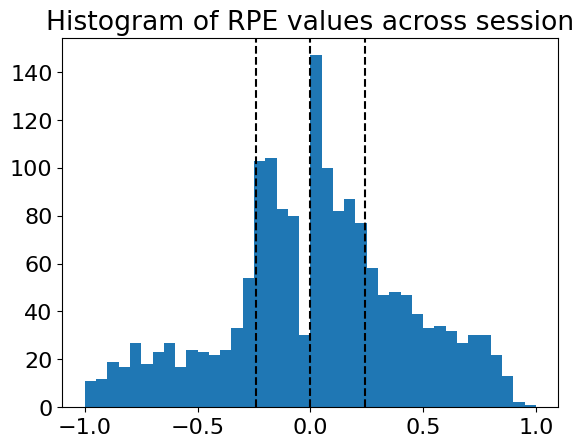

In [10]:
ax = beh_w_rpes.RPE_FE.hist(label="Feature Extended", bins=bins, grid=False)
neg_med = beh_w_rpes[beh_w_rpes.RPE_FE < 0].RPE_FE.median()
pos_med = beh_w_rpes[beh_w_rpes.RPE_FE > 0].RPE_FE.median()
ax.axvline(neg_med, alpha=1, color='black', linestyle='dashed')
ax.axvline(0, alpha=1, color='black', linestyle='dashed')
ax.axvline(pos_med, alpha=1, color='black', linestyle='dashed')
ax.set_title("Histogram of RPE values across session")

In [37]:
print(f"num negative trials: {len(beh_w_rpes[beh_w_rpes.RPE_FE < 0])}")
print(f"num positive trials: {len(beh_w_rpes[beh_w_rpes.RPE_FE > 0])}")

num negative trials: 751
num positive trials: 956


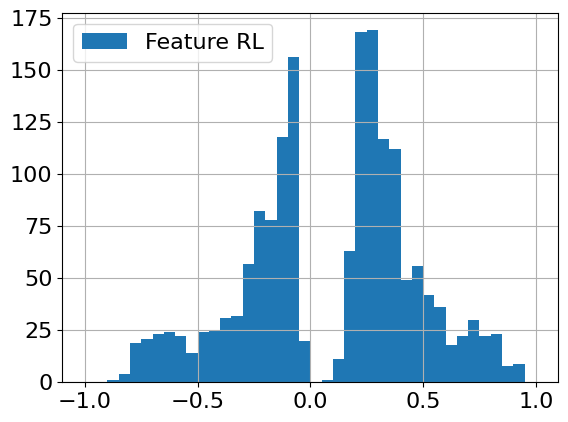

In [41]:
hist = beh_w_rpes.RPE_FRL.hist(label="Feature RL", bins=bins)
hist.legend()

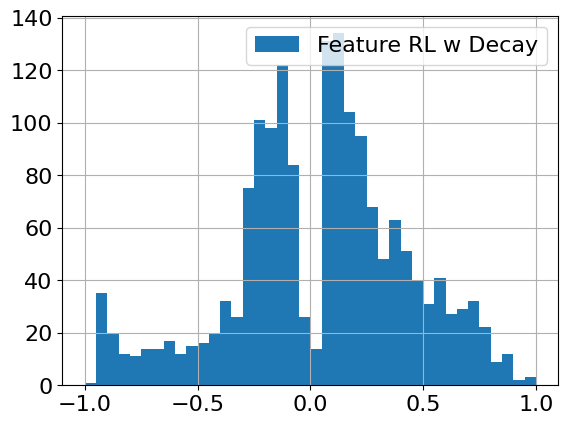

In [42]:
hist = beh_w_rpes.RPE_FD.hist(label="Feature RL w Decay", bins=bins)
hist.legend()

### How varying is the median absolute value across sessions? 

In [11]:
def calc_rpe_abs_median(row):
    session = row.session_name
    beh_path = f"/data/rawdata/sub-SA/sess-{session}/behavior/sub-SA_sess-{session}_object_features.csv"
    beh = pd.read_csv(beh_path)
    valid_beh = behavioral_utils.get_valid_trials(beh)
    try: 
        beh_w_rpes = get_rpes_per_session(session, valid_beh)
    except: 
        return None
    assert len(valid_beh) == len(beh_w_rpes)
    # return {
    #     "FE_abs_median": beh_w_rpes.RPE_FE.abs().median(),
    #     "FD_abs_median": beh_w_rpes.RPE_FD.abs().median(),
    #     "FRL_abs_median": beh_w_rpes.RPE_FRL.abs().median(),
    # }
    row["FE_abs_median"] = beh_w_rpes.RPE_FE.abs().median()
    row["FD_abs_median"] = beh_w_rpes.RPE_FD.abs().median()
    row["FRL_abs_median"] = beh_w_rpes.RPE_FRL.abs().median()
    return row
    
valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions.pickle")
valid_sess_rpe = valid_sess.apply(calc_rpe_abs_median, axis=1)
valid_sess_rpe = valid_sess_rpe.dropna()

In [75]:
valid_sess_rpe.to_pickle("/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle")

In [68]:
valid_sess_rpe.FE_abs_median.std()

0.008890156321447273

In [74]:
valid_sess_rpe.FE_abs_median.mean()

0.24555812930396223

In [69]:
valid_sess_rpe.FD_abs_median.std()

0.009507928312025784

In [70]:
valid_sess_rpe.FRL_abs_median.std()

0.016189985329167947

### How about the quantiles of RPEs? 

In [15]:
def calc_rpe_abs_median(row):
    session = row.session_name
    beh_path = f"/data/rawdata/sub-SA/sess-{session}/behavior/sub-SA_sess-{session}_object_features.csv"
    beh = pd.read_csv(beh_path)
    valid_beh = behavioral_utils.get_valid_trials(beh)
    beh_w_rpes = get_rpes_per_session(session, valid_beh)
    assert len(valid_beh) == len(beh_w_rpes)
    row["FE_quantile_25"] = beh_w_rpes.RPE_FE.quantile(q=0.25)
    row["FD_quantile_25"] = beh_w_rpes.RPE_FD.quantile(q=0.25)
    row["FRL_quantile_25"] = beh_w_rpes.RPE_FRL.quantile(q=0.25)
    row["FE_quantile_75"] = beh_w_rpes.RPE_FE.quantile(q=0.75)
    row["FD_quantile_75"] = beh_w_rpes.RPE_FD.quantile(q=0.75)
    row["FRL_quantile_75"] = beh_w_rpes.RPE_FRL.quantile(q=0.75)
    return row
    
valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle")
valid_sess_rpe = valid_sess.apply(calc_rpe_abs_median, axis=1)

In [16]:
print(valid_sess_rpe["FE_quantile_25"].mean())
print(valid_sess_rpe["FE_quantile_25"].std())
print(valid_sess_rpe["FE_quantile_75"].mean())
print(valid_sess_rpe["FE_quantile_75"].std())


-0.18780320032224368
0.021518556129153293
0.30816902710075833
0.022230225871920643


In [17]:
valid_sess_rpe.to_pickle("/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle")

### What about positive/negative median RPEs?

In [45]:
def calc_neg_pos_rpe_median(row):
    session = row.session_name
    beh_path = f"/data/rawdata/sub-SA/sess-{session}/behavior/sub-SA_sess-{session}_object_features.csv"
    beh = pd.read_csv(beh_path)
    valid_beh = behavioral_utils.get_valid_trials(beh)
    try: 
        beh_w_rpes = get_rpes_per_session(session, valid_beh)
    except: 
        return None
    assert len(valid_beh) == len(beh_w_rpes)

    neg_med = beh_w_rpes[beh_w_rpes.RPE_FE < 0].RPE_FE.median()
    pos_med = beh_w_rpes[beh_w_rpes.RPE_FE > 0].RPE_FE.median()
    row["FE_neg_median"] = neg_med
    row["FE_pos_median"] = pos_med
    return row
    
valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle")
valid_sess_rpe = valid_sess.apply(calc_neg_pos_rpe_median, axis=1)
valid_sess_rpe = valid_sess_rpe.dropna()

In [49]:
valid_sess_rpe.to_pickle("/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle")

In [47]:
valid_sess_rpe.FE_neg_median.std()

0.015219578496080268

In [48]:
valid_sess_rpe.FE_pos_median.std()

0.026589943717834547